# Tutorial for reflectance calculations with phase in the structural-color package

Copyright 2023

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Introduction to how fields are implemented in the package

When simulating the scattering of light waves, it's intuitive that we need to consider their fields. Keeping track of fields of the Monte Carlo trajectories requires us to more deeply examine what each trajectory represents and how fields should be calculated and propagated. In our model, we sometimes refer to the light trajectories as photons, or photon packets. These descriptions, however, are not perfect metaphors for what we are actually modeling. A more intuitive way to think of them is as a packet of light that has both wave and particle qualities. Within one trajectory, we can keep track of a field. The foundation of our model also means that we consider the interference that takes place within one trajectory. The calculation of the form and struture factor for each trajectory determines how constructive interference affects the path of the trajectory and its field. 

But the foundation of our model ignores the interactions *between* the trajectories. That is, the interference between the different photons. In order to track potential interference effects between trajectories, we must keep track of the field of the trajectory as it scatters and moves through the structurally colored material. 

At first glance, one might argue that there is no need to consider the interference between trajectories. After all, we are using an incoherent light source. But this isn't quite true. The coherence length of many incoherent light sources is on the scale of tens of microns, and photons can travel shorter distances than that before exiting the sample. In addition, the fact that the structure factor leads to interference peaks offers proof that interference matters even when we have an incoherent light source. But then again, if most of the structure factor interference peak contributions come from single scattering, perhaps the interference only affects light in terms of the structure factor, which is already accounted for. However, there are also other interference effects that can occur in disordered systems such as the ones addressed by this model. Take, for example, coherent backscattering, which is the constructive interference that comes from multiply scattering photons travelling reverse paths to one another. To capture such an effect, we would need to track the field for each trajectory as it moves.

To accurately calculate trajectory fields and their propagation, 
we have to modify or add calculations in several places throughout the structural-color package:

1. Mie cross-sections
<br>
In the single scattering model used in this package, the cross sections are proportional to the structure factor * form factor, where the form factor comes from Mie theory. Mie theory solves Maxwell's equations for spheres, giving the scattered electric fields, which we use to calculate scattered intensity and scattering cross sections. The Mie solutions give the full fields--this includes information on polarizatin and phase. We use Mie theory to find Jones or Stokes vectors to describe the fields. 
<br>
<br>
Most Mie solutions are performed in a basis defined by the scattering plane. So the Jones vector describes the scattered electric field components in terms of the scattered light that has polarization parallel to the scattering plane and the scattered light that is perpendicular to the scattering plane. (Remember, the scattering plane is the plane that contains the incident and scattered k-vectors of the light). Here's the way the Jones vector is written in this basis:
<br>
<br>
$E_{scat} = \begin{bmatrix}E_{||} \\ E_{\perp}\end{bmatrix}$
<br>
<br>
This scattering plane basis is not ideal if you want to actually compare to any measured polarizations, because in the lab, we do not measure polarization according to its relation to the scattering plane, we measure it in the lab frame, which is not related to the scattering vectors of the light at all. And more specifically, we like to measure things in cartesian coordinates because it's intuitive. So we rotate the scattering matrix that comes from the Mie calculations, which allows us to get an expression for the Jones vector in a cartesian basis. 
<br>
<br>
$E_{scat} = \begin{bmatrix}E_{x} \\ E_{y}\end{bmatrix}$
<br>
<br>
Now looking at this expression, you'll notice that there is no z component. The absence of z happens because we are assuming that the light is traveling in the +z direction, and under circumstances relevant to the model, polarization cannot be parallel to the direction of propagation. At this point, we can calculate the scattering cross-sections in this cartesian coordinate system by doing a bit of math. To read more about this, see the docstrings of functions in mie.py. I worked very hard on them, and there is no point in repeating them here. 
<br>
<br>
2. Field vector
<br>
The field vector tells us the amplitude, polarization, and phase of the fields of light waves. It's often expressed as a Stokes or Jones vector, and it can be calculated by normalizing the above $E_{scat}$.  
<br>
Again, we have to be careful with coordinates. This Jones vector is in a cartesian coordinate system that is no longer dependent on the incident and scattered vectors as the scattering plane basis is. But this cartesian coordinate system is not the one we care about for comparing to measurements. Why? Because these coordinates are are defined in the local coordinate system of the light, or a photon packet, in the language of the Monte Carlo model. No matter the global direction of the light, it always sees itself as traveling in its own +z direction. If it changes direction, as it will in the Monte Carlo model, it rotates its coordinate system, so that it always is traveling in its own +z direction. 
<br>
<br>
We experimentalists do not care what direction the photon packet thinks it is traveling in; we care about the direction relative to our own world: the global lab frame. So we do another rotation, one that brings the expression for the field into a global cartesian coordinate system that assumes the normal to a film sample is in the -z direction, meaning normally incident light travels in the +z direction. The +x, and +y directions can be found according to right hand rule. So our new expression for the E-field has 3 components:
<br>
<br>
$ E_{scat} = \begin{bmatrix}E_{x} \\ E_{y}\\ E_{z}\end{bmatrix}$
<br>
<br>
This is the format of the field vectors that are attributes of a Trajectory object. The Mie solutions give the full polarization and phase information for the scattered field, and multiply by the square root of the weight (which represents an intensity) to get the amplitude of the field component. For more details, see calc_fields() in montecarlo.py and calc_refl_phase_fields() in detector_polarization_phase.py 
<br>
<br> 
3. Field vector propagation
<br>
As a trajectory travels, we propagate its phase forward based on the length of its step size. 
<br>
<br>
$E_{scat} = Ee^{ik*\textrm{step}}$
<br>
<br>
4. Phase function
<br>
The final place the polarization comes in is in the phase function. The phase function is the probability distribution of scattering angles, and it's calculated by just normalizing the differential cross section:
<br>
<br>
$p(\theta, \phi) = \frac{\frac{d\sigma(\theta, \phi)}{d\Omega}}{\sigma}$
<br>
<br>
You'll notice that it's a function of $\theta$ and $\phi$. For unpolarized light, we don't have to worry about the $\phi$ dependence in our samples because both the structure factors and the form factors for unpolarized light are constant as a function of $\phi$. Polarized light is a different story. For polarized incident light, we do have to calculate the phase function as a function of $\theta$ and $\phi$.
<br>
<br>
Having a phase function that depends on two variables means that our phase function is now a 2-dimentional array instead of a 1-dimensional array, and the sampling of the angles is a bit more complicated and time-consuming. This is all under the hood though--you (the user) won't have to fuss with the different possible dimensions of the phase function, but I think it's good to know in case you ever want to plot the phase function.  

**FAQ**

Q: If polarization/phase is always calculated in Mie theory, what do we do with it in the calculations where we assume the light is unpolarized? 
<br>
A: We average the parallel and perpendicular components of polarization. This is derived on pg 73 of Bohren and Huffman's $\textit{Absorption and Scattering of Light by Small Particles}$. 


Q: Is polarization implemented in both the single scattering model and the Monte Carlo model?
<br>
A: Currently, polarization is only fully implemented in the Monte Carlo model. However, it is certainly possible to add it to the single scattering model in the future

<br>
Q: Why don't we calculate a phase shift contribution based on the structure factor?
<br>
A: The structure factor appears in our model in the calculation of both the scattering length and the phase function. This means the structure factor helps determine both the direction of scattering and the distance between scattering events. There is no obvious phase propagation that should come from considering the structure factor. Since the structure factor is by definition the sum of the phase contributions of the scattered waves from all the particles in the system, we see that the structure factor is simply a result of the addition of the scattered fields. It's not a separate scattering event that can be seen as causing a phase shift. The field which is itself scattered in this system can be described from Mie theory, so we need only consider the phase shift due to Mie theory and propagation. 

### Loading and using the package

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
from structcol import refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
from structcol import detector_polarization_phase as detp
import seaborn as sns

In [3]:
# The following will cause specific warnings to be ignored
import warnings
warnings.filterwarnings('ignore',
                        category=UserWarning,
                        message='.*n_particle and n_matrix not specified')

So that you can reproduce the results in this notebook, we use a seeded random number generator. The code will then produce the same trajectories each time. For your own code, you should change the cell below to read `rng=None`, or set up your own random number generator.

In [4]:
seed = 1
rng = np.random.RandomState([seed])
# Uncomment the following for your own code
#rng = None

### Run Monte Carlo model and calculate reflectance and fields for trajectories
#### for a single wavelength

In [5]:
# incident light wavelength
wavelength = sc.Quantity('600 nm')

# sample parameters
radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '')
n_imag = 2.1e-4
n_particle = ri.n('polystyrene', wavelength) + n_imag*1j    # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelength)      # called from the refractive_index module. n_matrix is the
n_medium = ri.n('vacuum', wavelength)      # space within sample. n_medium is outside the sample
n_sample = ri.n_eff(n_particle,            # refractive index of sample, calculated using Bruggeman approximation
                    n_matrix,
                    volume_fraction)
thickness = sc.Quantity('800 um')
boundary = 'film'

# Monte Carlo parameters
ntrajectories = 2000                # number of trajectories
nevents = 300                       # number of scattering events in each trajectory

initialize and run trajectories

In [6]:
# Calculate scattering quantities
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample,
                                  volume_fraction, wavelength,
                                  fields=True)

# Initialize trajectories
r0, k0, W0, E0 = mc.initialize(nevents, ntrajectories,
                               n_medium, n_sample, boundary,
                               coherent=False,
                               fields=True, rng=rng)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')
E0 = sc.Quantity(E0,'')

trajectories = mc.Trajectory(r0, k0, W0, fields=E0)

# Sample trajectory angles
sintheta, costheta, sinphi, cosphi, theta, phi= mc.sample_angles(nevents,
                                                                 ntrajectories,
                                                                 p, rng=rng)
# Sample step sizes
step = mc.sample_step(nevents, ntrajectories, mu_scat, rng=rng)

# Update trajectories based on sampled values
trajectories.scatter(sintheta, costheta, sinphi, cosphi)
trajectories.calc_fields(theta, phi, sintheta, costheta, sinphi, cosphi,
                         n_particle, n_sample, radius, wavelength, step, volume_fraction,
                         fine_roughness=0, tir_refl_bool=None)
trajectories.move(step)
trajectories.absorb(mu_abs, step)

calculate reflectance

In [7]:
refl_trans_result = det.calc_refl_trans(trajectories, thickness,
                                        n_medium, n_sample, boundary,
                                        return_extra=True)

reflectance = refl_trans_result[11]
refl_indices = refl_trans_result[0]
refl_per_traj = refl_trans_result[3]

# calculate reflectance including phase
refl_trans_result = det.calc_refl_trans(trajectories, thickness,
                                        n_medium, n_sample, boundary,
                                        return_extra=True)

refl_indices = refl_trans_result[0]
refl_per_traj = refl_trans_result[3]
refl_fields, _ = detp.calc_refl_phase_fields(trajectories,
                                             refl_indices,
                                             refl_per_traj)


print('Reflectance with fields: ' + str(refl_fields))
print('Reflectance: ' + str(reflectance))

Reflectance with fields: 0.3848868020860198
Reflectance: 0.4216450105698871


### Run Monte Carlo model and calculate reflectance for trajectories
#### for the full visible spectrum

In [8]:
seed = 1
rng = np.random.RandomState([seed])
# Uncomment the following for your own code
#rng = None

In [9]:
# incident light wavelength
wavelengths = sc.Quantity(np.arange(440, 780, 20), 'nm')

# sample parameters
radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '')
n_imag = 2.1e-5
n_particle = ri.n('polystyrene', wavelengths) + n_imag*1j  # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelengths)      # called from the refractive_index module. n_matrix is the
n_medium = ri.n('vacuum', wavelengths)      # space within sample. n_medium is outside the sample

thickness = sc.Quantity('80 um')
z_low = sc.Quantity('0 um')

# Monte Carlo parameters
ntrajectories = 500                   # number of trajectories
nevents = 150                       # number of scattering events in each trajectory

# polarization detector parameters
det_theta = sc.Quantity('10 deg')

Initialize trajectories, run trajectories, and calculate reflectance for each wavelength.  This takes a minute or two to run!

In [10]:
reflectance = np.zeros(wavelengths.size)
refl_tot = np.zeros(wavelengths.size)
refl_co = np.zeros(wavelengths.size)
refl_cr = np.zeros(wavelengths.size)
refl_perp = np.zeros(wavelengths.size)
refl_field = np.zeros(wavelengths.size)
refl_intensity = np.zeros(wavelengths.size)

for i in range(wavelengths.size):
    # print wavelength
    print('wavelength: ' + str(wavelengths[i]))

    # calculate n_sample
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction)

    # Calculate scattering quantities
    p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle[i], n_sample,
                                      volume_fraction, wavelengths[i],
                                      fields=True)

    # Initialize trajectories
    r0, k0, W0, E0 = mc.initialize(nevents, ntrajectories, n_medium[i], n_sample, boundary,
                                   fields=True, coherent=False, rng=rng)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')
    E0 = sc.Quantity(E0,'')

    trajectories = mc.Trajectory(r0, k0, W0, E0)

    # Sample trajectory angles
    sintheta, costheta, sinphi, cosphi, theta, phi= mc.sample_angles(nevents,
                                                                     ntrajectories,
                                                                     p, rng=rng)
    # Sample step sizes
    step = mc.sample_step(nevents, ntrajectories, mu_scat, rng=rng)

    # Update trajectories based on sampled values
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)
    trajectories.move(step)
    trajectories.absorb(mu_abs, step)
    trajectories.calc_fields(theta, phi, sintheta, costheta, sinphi, cosphi,
                             n_particle[i], n_sample, radius,
                             wavelengths[i], step, volume_fraction,
                             fine_roughness=0, tir_refl_bool=None)

    # calculate reflectance and other values of interest
    refl_trans_result = det.calc_refl_trans(trajectories,thickness,
                                            n_medium[i], n_sample,
                                            boundary, return_extra=True)
    reflectance[i] = refl_trans_result[11]
    refl_indices = refl_trans_result[0]
    refl_per_traj = refl_trans_result[3]

    # calculate reflectance including fields
    refl_fields, _ = detp.calc_refl_phase_fields(trajectories,
                                                 refl_indices,
                                                 refl_per_traj)

    # calculate reflectance contribution from each polarization component
    (refl_co[i],
     refl_cr[i],
     refl_perp[i],
     refl_field[i],
     refl_intensity[i]) = detp.calc_refl_co_cross_fields(trajectories,
                                                      refl_indices,
                                                      refl_per_traj,
                                                      det_theta)


wavelength: 440 nanometer
wavelength: 460 nanometer
wavelength: 480 nanometer
wavelength: 500 nanometer
wavelength: 520 nanometer
wavelength: 540 nanometer
wavelength: 560 nanometer
wavelength: 580 nanometer
wavelength: 600 nanometer
wavelength: 620 nanometer
wavelength: 640 nanometer
wavelength: 660 nanometer
wavelength: 680 nanometer
wavelength: 700 nanometer
wavelength: 720 nanometer
wavelength: 740 nanometer
wavelength: 760 nanometer


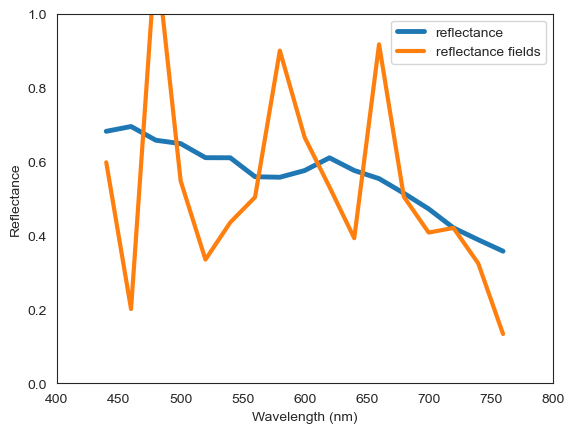

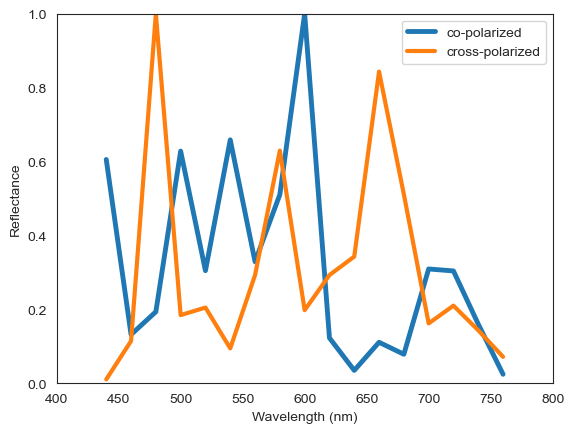

In [12]:
sns.set_style('white')
plt.figure()
plt.plot(wavelengths.magnitude, refl_intensity , label = 'reflectance', linewidth = 3.5)
plt.plot(wavelengths.magnitude, refl_field, label = 'reflectance fields', linewidth = 3)
plt.xlim([400,800])
plt.ylim([0,1])
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.legend()

sns.set_style('white')
plt.figure()
plt.plot(wavelengths.magnitude, refl_co/np.max(refl_co) , label = 'co-polarized', linewidth = 3.5)
plt.plot(wavelengths.magnitude, refl_cr/np.max(refl_cr), label = 'cross-polarized', linewidth = 3)
plt.xlim([400,800])
plt.ylim([0,1])
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.legend();